In [1]:
import os

import earthpy as et
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show
import requests
from shapely.geometry import box
import warnings
import zipfile

warnings.filterwarnings("ignore")

# The Boulder Watershed Collective Project Area

In [2]:
shape_file_path = '../assets/areas/immediate_project/Zumwinkel_property.shp'
aoi_gdf = gpd.read_file(shape_file_path)

In [3]:
aoi_gdf.hvplot(
        geo=True, tiles='OSM', alpha=1, 
        height=600, width=800, color='red',
        label='Area of Interest'
    )

:Overlay
   .WMTS.I                    :WMTS   [Longitude,Latitude]
   .Polygons.Area_of_Interest :Polygons   [Longitude,Latitude]

# Denver Regional Aerial Photography Project (DRAPP) 2020

In [4]:
# Define directories and filepaths
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'treebeard')

# Data Set #1: Denver Regional Aerial Imagery Boundary
drapp_url = (
    'https://gisdata.drcog.org:8443'
    '/geoserver/DRCOGPUB/ows?'
    'service=WFS&version=1.0.0&'
    'request=GetFeature&'
    'typeName=DRCOGPUB:drapp_tile_scheme_2020'
    '&outputFormat=SHAPE-ZIP'
)
drapp_shp_file = os.path.join(data_dir, 'drapp_tile_scheme_2020', 'drapp_tile_scheme_2020.shp')
drapp_dir = os.path.join(data_dir, 'drapp_tile_scheme_2020')

# Data Set #2: Denver Regional Aerial Imagery Tiles
drapp_tiles_dir = os.path.join(data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

In [5]:
if not os.path.exists(drapp_shp_file):
    drapp_resp = requests.get(drapp_url)
else:
    print('Data already downloaded.')

Data already downloaded.


In [6]:
def extract_zip(target_dir, zip_filename, resp):
    zip_path = os.path.join(data_dir, zip_filename)
    with open(zip_path, 'wb') as f:
        f.write(resp.content)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)

In [7]:
drapp_dir = os.path.join(data_dir, 'drapp_tile_scheme_2020')
if not os.path.exists(drapp_shp_file):
    extract_zip(data_dir, 'drapp_tile_scheme_2020.zip', drapp_resp)
else:
    print('Data already downloaded.')

Data already downloaded.


In [8]:
bbox_aoi_gdf = gpd.GeoDataFrame(geometry=aoi_gdf.bounds.apply(lambda row: box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1))
bbox_aoi_gdf.crs = aoi_gdf.crs
drapp_gdf = gpd.read_file(drapp_shp_file)
drapp_gdf = drapp_gdf.to_crs(aoi_gdf.crs) # EPSG:6428 -> EPSG:4326

In [9]:
drapp_aoi_gdf = gpd.sjoin(drapp_gdf, aoi_gdf, how='inner', predicate='intersects')

## Identified the one tile that covers the Boulder Watershed Collective Project Area out of 10135 tiles

In [10]:
aoi_plot = aoi_gdf.hvplot(
        geo=True, tiles='OSM', alpha=1, 
        height=600, width=800, color='red',
        label='Area of Interest'
    )
aoi_bound_plot = bbox_aoi_gdf.hvplot(
        geo=True, tiles='OSM', alpha=0.7, 
        height=600, width=800, color='blue',
        label='AOI Bounding Box'
    )
drapp_plot = drapp_aoi_gdf.hvplot(
        geo=True, tiles='OSM', 
        alpha=0.3, color='blue',
        height=600, width=800,
        hover_cols=['tile', 'photo_date'],
        title='Area of Interest in DRAPP Tile N4W351'
    )
aoi_bound_plot * drapp_plot * aoi_plot

:Overlay
   .WMTS.I                    :WMTS   [Longitude,Latitude]
   .Polygons.AOI_Bounding_Box :Polygons   [Longitude,Latitude]
   .WMTS.II                   :WMTS   [Longitude,Latitude]
   .Polygons.I                :Polygons   [Longitude,Latitude]   (tile,photo_date)
   .WMTS.III                  :WMTS   [Longitude,Latitude]
   .Polygons.Area_of_Interest :Polygons   [Longitude,Latitude]

In [11]:
tile_base_url = 'https://drapparchive.s3.amazonaws.com/2020/'
tile_urls = [f'{tile_base_url}{tile}.tif' for tile in drapp_aoi_gdf['tile'].unique()]

In [12]:
drapp_tiles_dir = os.path.join(data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

def download_files(urls):
    paths = []
    for url in urls:
        filename = os.path.basename(url)
        path = os.path.join(drapp_tiles_dir, filename)
        paths.append(path)
        if not os.path.exists(path):
            print(f"Downloading {url}...")
            resp = requests.get(url)
            with open(path, 'wb') as f:
                f.write(resp.content)
        else:
            print(f"File {filename} already downloaded.")
    return paths
tile_paths = download_files(tile_urls)

File N4W351.tif already downloaded.


In [13]:
photo_date = pd.to_datetime(
        drapp_aoi_gdf['photo_date']
    ).dt.date.unique()[0].strftime('%Y-%m-%d')
tile_name = drapp_aoi_gdf['tile'].unique()[0]

## Downloaded the one tile from the DRAPP 2020 dataset (Tile N4W351)

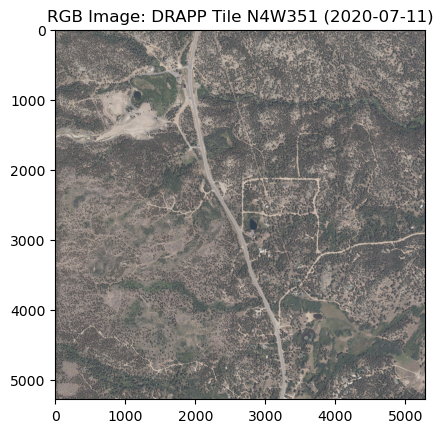

In [14]:
# Open all the files
src_files_to_mosaic = [rasterio.open(path) for path in tile_paths]
mosaic, out_trans = merge(src_files_to_mosaic)
red = mosaic[0]
green = mosaic[1]
blue = mosaic[2]
nir = mosaic[3]
rgb = np.dstack((red, green, blue))
plt.imshow(rgb)
plt.title(f'RGB Image: DRAPP Tile {tile_name} ({photo_date})')
plt.savefig('../images/N4W351_rgb_image.png')
plt.show()

## Cropped & saved the area of interest bounding box area as a GeoTIFF file

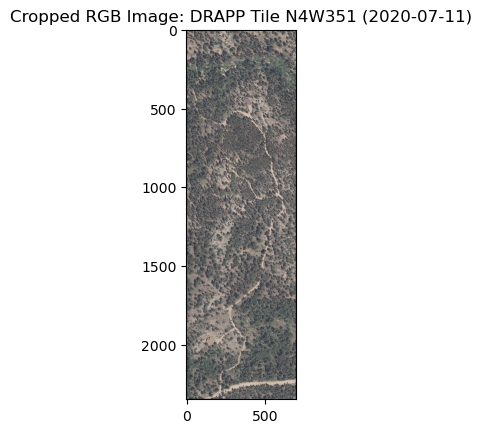

In [16]:
# Open the GeoTIFF file
with rasterio.open(tile_paths[0]) as src:
    # Make sure the GeoDataFrame's CRS matches the raster's CRS
    # Raster: EPSG:6428 (Unit: US survey foot)
    if bbox_aoi_gdf.crs != src.crs:
        bbox_aoi_gdf = bbox_aoi_gdf.to_crs(src.crs)

    # Create a mask for cropping
    geom = [bbox_aoi_gdf.geometry.unary_union]  # Combines all geometries in the GeoDataFrame
    out_image, out_transform = mask(src, geom, crop=True)

    # Update the metadata for the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

cropped_file = "../scratch/cropped_N4W351.tif"
with rasterio.open(cropped_file, "w", **out_meta) as dest:
    dest.write(out_image)

# Open the cropped GeoTIFF file
with rasterio.open(cropped_file) as src:
    # Read the cropped raster
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    rgb = np.dstack((red, green, blue))

    # Plot the cropped RGB image
    plt.imshow(rgb)
    plt.title(f'Cropped RGB Image: DRAPP Tile {tile_name} ({photo_date})')
    plt.savefig('../images/cropped_N4W351_rgb_image.png')
    plt.show()